<a href="https://colab.research.google.com/github/cruz-marco/50_startups/blob/main/50_Startups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Importando bibliotecas.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, kstest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# 1.0 Carregando o dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Startups/50_Startups.csv')

In [5]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [84]:
df.shape

(49, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


- Por hora, sem valores nulos.

# 2.0 Análise exploratória dos dados

## 2.1 Visualizando descrição dos dados numéricos.

In [45]:
describe = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T
describe

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,14086.703,39936.3700,73051.080,101602.8000,135364.648,164000.9650,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,85013.773,103730.8750,122699.795,144842.1800,153540.042,170419.2564,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,34814.225,129300.1325,212716.240,299469.0850,363192.066,458120.1707,471784.10
Profit,50.0,112012.6392,40306.180338,14681.40,65172.905,90138.9025,107978.190,139765.9775,157910.802,192031.6427,192261.83


## 2.2 Visualizando histogramas das variáveis numéricas.

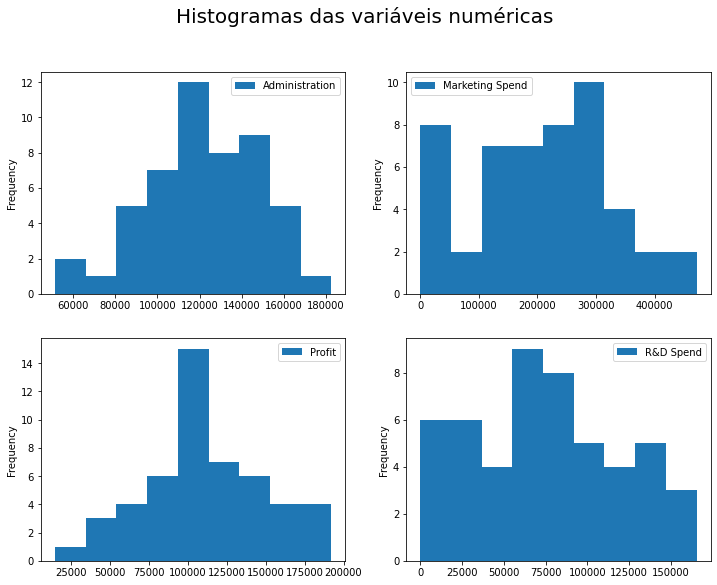

In [11]:
numeric_vars = sorted(tuple(df.select_dtypes(include='number').columns))[::-1]

nv_index = len(numeric_vars) - 1 

ncols = 2
nrows = int(np.ceil(len(numeric_vars)/(1.0 * ncols)))



fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

fig.suptitle('Histogramas das variáveis numéricas', fontsize=20)


for lines in axes: #itera nas linhas
    for cols in lines: #itera nas colunas dentro das linhas
        if nv_index >= 0:  #verifica o indice a ser usado

            linha = np.where(axes == lines)[0][0] #pega o index da linha
            coluna = np.where(lines == cols)[0][0] #pega o index da coluna

            df[numeric_vars[nv_index]].plot.hist(bins=9, 
            label=numeric_vars[nv_index].replace('_', ' ').title(), 
            subplots=True, legend=True, ax=axes[linha, coluna])
      
            nv_index -= 1

        else:
            plt.axis('off')


plt.show()

### 2.2.1 Teste de normalidade

In [82]:
nrm_test = list()

for var in numeric_vars:
    ks, pvalue = kstest(df[var], cdf = 'norm')
    nrm_test.append({
        'Variavel': var,
        'Estatistica KS': ks,
        'p-valor': pvalue
    })
    
print(*sorted(nrm_test, key=lambda x: x['Estatistica KS']), sep='\n')

{'Variavel': 'Marketing Spend', 'Estatistica KS': 0.9387755102040817, 'p-valor': 7.250445743039556e-60}
{'Variavel': 'R&D Spend', 'Estatistica KS': 0.9795918367346939, 'p-valor': 3.029856599928581e-83}
{'Variavel': 'Profit', 'Estatistica KS': 1.0, 'p-valor': 0.0}
{'Variavel': 'Administration', 'Estatistica KS': 1.0, 'p-valor': 0.0}


- Nenhuma das variáveis apresenta uma distribuição normal.

## 2.3 Visualizando boxplot das variáveis numéricas.

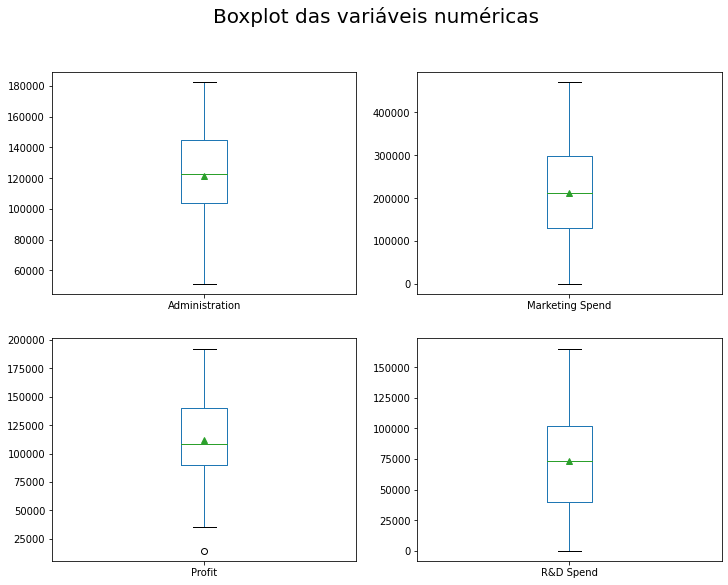

In [28]:
nv_index = len(numeric_vars) - 1 

ncols = 2
nrows = int(np.ceil(len(numeric_vars)/(1.0 * ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

fig.suptitle('Boxplot das variáveis numéricas', fontsize=20)

for lines in axes: #itera nas linhas
    for cols in lines: #itera nas colunas dentro das linhas
        if nv_index >= 0:  #verifica o indice a ser usado
            
            linha = np.where(axes == lines)[0][0] #pega o index da linha
            coluna = np.where(lines == cols)[0][0] #pega o index da coluna

            df.boxplot(column=numeric_vars[nv_index], grid=False,
            vert=True, showmeans=True, ax=axes[linha, coluna])
            
            nv_index -= 1
        else:
            plt.axis('off')

plt.show()

- Temos apenas um outlier na variável profit.
- Por ser um trabalho de regressão, parece conveniente eliminá-lo.

In [88]:
#Definindo uma função para remover os outliers do dataframe de determinadas
#colunas.

def outlier_remover(dataframe, columns: list):
  desc = dataframe.describe().T

  for column in columns:
    q1 = desc.loc[column, '25%']
    q3 = desc.loc[column, '75%']
    bounds = (q1-(1.5*(q3-q1)), q3+(1.5*(q3-q1)))
    dataframe = dataframe[(df[column] > bounds[0]) & (df[column] < bounds[1])]
  
  return dataframe
    

In [89]:
df = outlier_remover(df, ['Profit'])
df.shape

#outliers removidos

(49, 5)

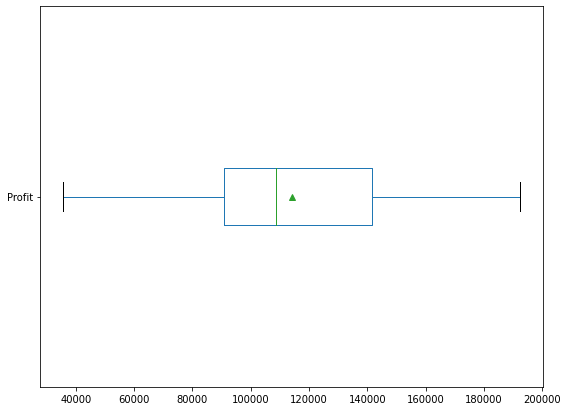

In [90]:
fig = plt.figure(figsize=(9,7))

df.boxplot(column='Profit', grid=False,
            vert=False, showmeans=True)

plt.show()

## 2.4 Verificando variável categórica.

In [86]:
print({
    'Coluna': 'State',
    'N/A': df['State'].isna().sum(),
    'Unique': tuple(df['State'].unique()),
    'Uniq-len': len(df['State'].unique())
  })

{'Coluna': 'State', 'N/A': 0, 'Unique': ('New York', 'California', 'Florida'), 'Uniq-len': 3}


- 3 Categorias detectadas.

# 3.0 Processamento

## 3.1 Categórica State

In [99]:
dummyState = pd.get_dummies(df['State'], prefix='st', prefix_sep='_',
                            drop_first=True)

## 3.2 Juntando variáveis categóricas e numéricas

In [102]:
df = pd.concat([dummyState, df], axis=1).drop(columns=['State'])

In [105]:
df.head()

,st_Florida,st_New York,R&D Spend,Administration,Marketing Spend,Profit
0,0,1,165349.20,136897.80,471784.10,192261.83
1,0,0,162597.70,151377.59,443898.53,191792.06
2,1,0,153441.51,101145.55,407934.54,191050.39
3,0,1,144372.41,118671.85,383199.62,182901.99
4,1,0,142107.34,91391.77,366168.42,166187.94


## 3.3 Separando variável dependente das independentes

In [107]:
X = df.drop(columns=['Profit'])
y = df['Profit']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [109]:
print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)

(39, 5) (10, 5) (39,) (10,)


## 3.4 Normalizando os datasets

In [243]:
normalizer = Normalizer()
normalizer.fit(X_train[['R&D Spend',	'Administration',	'Marketing Spend']])

Normalizer()

In [244]:
norm_train_numbers = normalizer.transform(X_train[['R&D Spend', 'Administration', 'Marketing Spend']])
norm_test_numbers = normalizer.transform(X_test[['R&D Spend', 'Administration', 'Marketing Spend']])

cat_train = np.array(X_train[['st_Florida', 'st_New York']])
cat_test = np.array(X_test[['st_Florida', 'st_New York']])

X_trainN = np.concatenate((cat_train, norm_train_numbers), axis=1)
X_testN = np.concatenate((cat_test, norm_test_numbers), axis=1)

#  4.0 Modelagem

## 4.1 Treinando o modelo

In [245]:
reg = GradientBoostingRegressor(n_estimators=20, loss='squared_error',
                                max_depth=5)

In [246]:
reg.fit(X_trainN, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=20)

## 4.2 Aplicando o modelo

In [247]:
y_pred = reg.predict(X_testN)

## 4.3 Avaliando o modelo

In [248]:
residual = y_test - y_pred

In [249]:
print(
    f'R2: {r2_score(y_test, y_pred)}',
    f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}',
    f'MAE: {mean_absolute_error(y_test, y_pred)}', sep='\n'
)

R2: 0.8056883847351759
RMSE: 12556.213264395785
MAE: 9943.81929588321


## 4.4 Homocedasticidade

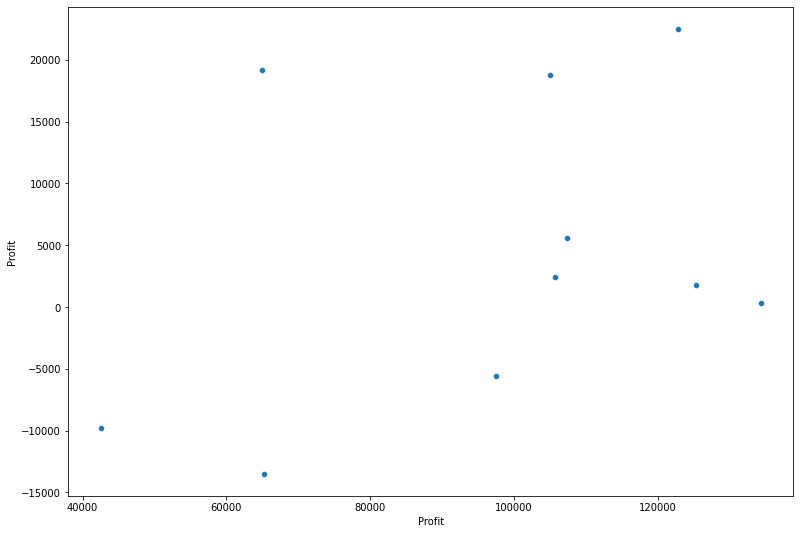

In [250]:
fig = plt.figure(figsize=(13,9))

sns.scatterplot(x=y_test, y=residual)

plt.show()